<a href="https://colab.research.google.com/github/atc857/eleicoes2022_2turno/blob/main/BU_TSE_2022_2T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de dados dos Boletins de Urna do TSE - 2022

Autor: André T. Campos

In [ ]:
import pandas as pd
import numpy as np

## Leitura dos dados

Fonte: https://dadosabertos.tse.jus.br/

In [ ]:
siglas = ['AC','AL','AP','AM','BA','CE','DF','ES','GO','MA','MT','MS','MG','PA','PB','PR','PE','PI','RJ','RN','RS','RO','RR','SC','SP','SE','TO','ZZ']

In [ ]:
for sigla in siglas:
  # Leitura dos dados de BU do TSE no 2º turno de 2022
  arquivo_tse = '/content/drive/MyDrive/Colab_Notebooks/TSE_BU_2022-2/bweb_2t_'+sigla+'_311020221535.csv'
  df = pd.read_csv(arquivo_tse, sep=';', encoding='Latin 1')

  #Retira linhas para o cargo de Governador
  df.drop(df[df.DS_CARGO_PERGUNTA=='Governador'].index, inplace=True)
  df.reset_index();

  df = df[['SG_UF', 'CD_MUNICIPIO','NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NM_VOTAVEL', 'QT_VOTOS','NR_URNA_EFETIVADA']]

  df['URNA_MODEL'] = np.where(df['NR_URNA_EFETIVADA']>=2000000,'UE-2020','OUTROS')

  # Pivotar a tabela para passar os nomes dos candidatos para colunas somando a quantidade de votos
  df2 = pd.pivot_table(df, index=['SG_UF','CD_MUNICIPIO','NM_MUNICIPIO','NR_ZONA','NR_SECAO','URNA_MODEL'], values='QT_VOTOS', columns='NM_VOTAVEL', aggfunc=np.sum, fill_value=0).reset_index()

  # Renomea e reordena as colunas
  df2.rename(columns={'SG_UF':'UF','NM_MUNICIPIO':'MUNICÍPIO','NR_ZONA':'ZONA','NR_SECAO':'SEÇÃO','JAIR BOLSONARO':'BOLSONARO'}, inplace = True)
  df2 = df2.iloc[:,[0,1,2,3,4,8,7,6,9,5]]

  filename = '/content/drive/MyDrive/Colab_Notebooks/TSE_BU_2022-2/csv/'+sigla+'.csv'
  df2.to_csv(filename, encoding='Latin 1', index=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
df2.head()

NM_VOTAVEL,UF,CD_MUNICIPIO,MUNICÍPIO,ZONA,SEÇÃO,LULA,BOLSONARO,Branco,Nulo,URNA_MODEL
0,ZZ,29173,KATMANDU,1,494,2,13,0,0,OUTROS
1,ZZ,29254,ABIDJÃ,1,1,26,15,2,0,OUTROS
2,ZZ,29262,ABU DHABI,1,1977,78,117,2,4,OUTROS
3,ZZ,29262,ABU DHABI,1,1978,66,132,2,6,OUTROS
4,ZZ,29262,ABU DHABI,1,1980,144,196,11,13,OUTROS


# Mapas

Insights muito bons em https://github.com/CarlosGrohmann/eleicoes_brasil/blob/main/eleicao_2022_boletins_de_urna.ipynb

In [ ]:
!pip install --upgrade geopandas --quiet
!pip install mapclassify --quiet
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


     |████████████████████████████████| 1.0 MB 12.3 MB/s 
     |████████████████████████████████| 16.7 MB 42.4 MB/s 
     |████████████████████████████████| 6.3 MB 63.8 MB/s 


## Concatenação dos dados

In [ ]:
# Lê os arquivos csv preparados e concatena em um dataframe
lista = []
for sigla in siglas:
  filename = '/content/drive/MyDrive/Colab_Notebooks/TSE_BU_2022-2/csv/'+sigla+'.csv'
  df = pd.read_csv(filename, encoding='Latin 1')
  lista.append(df)
df3 = pd.concat(lista, axis=0, ignore_index=True)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472028 entries, 0 to 472027
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   UF            472028 non-null  object
 1   CD_MUNICIPIO  472028 non-null  int64 
 2   MUNICÍPIO     472028 non-null  object
 3   ZONA          472028 non-null  int64 
 4   SEÇÃO         472028 non-null  int64 
 5   LULA          472028 non-null  int64 
 6   BOLSONARO     472028 non-null  int64 
 7   Branco        472028 non-null  int64 
 8   Nulo          472028 non-null  int64 
 9   URNA_MODEL    472028 non-null  object
dtypes: int64(7), object(3)
memory usage: 36.0+ MB


In [ ]:
# Agrupa as quantidades de votos por munícipio
df4 = pd.pivot_table(df3, index=['UF','MUNICÍPIO','CD_MUNICIPIO'], values=['LULA','BOLSONARO','Branco','Nulo'], aggfunc=np.sum, fill_value=0).reset_index()

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5710 entries, 0 to 5709
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   UF            5710 non-null   object
 1   MUNICÍPIO     5710 non-null   object
 2   CD_MUNICIPIO  5710 non-null   int64 
 3   BOLSONARO     5710 non-null   int64 
 4   Branco        5710 non-null   int64 
 5   LULA          5710 non-null   int64 
 6   Nulo          5710 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 312.4+ KB


In [ ]:
# Remove as urnas do exterior
df4.drop(df4[df4['UF'] == 'ZZ'].index, inplace = True)

## Dados Geoespaciais

Fonte: https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas/15759-brasil.html?=&t=downloads

In [ ]:
# Lê os dados de geocodigo do ibge no dataframe do tse
geo_tse = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Geo_mun/municipios_tse2.csv', encoding='utf8')
geo_tse.drop(['UF'], axis=1, inplace = True)
geo_tse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   nome_tse      5570 non-null   object
 1   CD_MUNICIPIO  5570 non-null   int64 
 2   geocodigo     5570 non-null   int64 
 3   nome_ibge     5570 non-null   object
dtypes: int64(2), object(2)
memory usage: 174.2+ KB


In [ ]:
# Adiciona coluna de geocodigo do ibge no dataframe do tse
df5 = pd.merge(geo_tse, df4, how='inner',on='CD_MUNICIPIO')
df5

,nome_tse,CD_MUNICIPIO,geocodigo,nome_ibge,UF,MUNICÍPIO,BOLSONARO,Branco,LULA,Nulo
0,ABADIA DE GOIÁS,93360,5200050,Abadia de Goiás,GO,ABADIA DE GOIÁS,5394,79,3814,110
1,ABADIA DOS DOURADOS,40010,3100104,Abadia dos Dourados,MG,ABADIA DOS DOURADOS,2160,50,2351,128
2,ABADIÂNIA,92010,5200100,Abadiânia,GO,ABADIÂNIA,5759,81,2774,155
3,ABAETÉ,40037,3100203,Abaeté,MG,ABAETÉ,7696,189,6302,264
4,ABAETETUBA,4014,1500107,Abaetetuba,PA,ABAETETUBA,25118,864,72313,1313
...,...,...,...,...,...,...,...,...,...,...
5565,XIQUE-XIQUE,39713,2933604,Xique-Xique,BA,XIQUE-XIQUE,5629,303,20301,1112
5566,ZABELÊ,19348,2517407,Zabelê,PB,ZABELÊ,241,18,1529,91
5567,ZACARIAS,61921,3557154,Zacarias,SP,ZACARIAS,1116,21,720,71
5568,ZÉ DOCA,9717,2114007,Zé Doca,MA,ZÉ DOCA,6313,183,17461,433


In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5570 entries, 0 to 5569
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   nome_tse      5570 non-null   object
 1   CD_MUNICIPIO  5570 non-null   int64 
 2   geocodigo     5570 non-null   int64 
 3   nome_ibge     5570 non-null   object
 4   UF            5570 non-null   object
 5   MUNICÍPIO     5570 non-null   object
 6   BOLSONARO     5570 non-null   int64 
 7   Branco        5570 non-null   int64 
 8   LULA          5570 non-null   int64 
 9   Nulo          5570 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 478.7+ KB


In [ ]:
# Arquivo de coordenadas espaciais Geopackage do IBGE
gdf_mun250 = None
gpkg_mun = '/content/drive/MyDrive/Colab_Notebooks/Geo_mun/bc250_municipios.gpkg'
gdf_mun250 = gpd.read_file(gpkg_mun, layer='lml_municipio_a')
gdf_mun250

,nome,geometriaaproximada,geocodigo,anodereferencia,geometry
0,Acajutiba,Não,2900306,None,"MULTIPOLYGON (((-38.08154 -11.61072, -38.08087..."
1,Aporá,Não,2901908,None,"MULTIPOLYGON (((-38.14169 -11.80348, -38.14440..."
2,Campestre do Maranhão,Não,2102556,None,"MULTIPOLYGON (((-47.04383 -6.19768, -47.04673 ..."
3,Porto Murtinho,Não,5006903,None,"MULTIPOLYGON (((-56.94176 -21.59373, -56.94243..."
4,Pimenteiras do Oeste,Não,1101468,None,"MULTIPOLYGON (((-60.91895 -13.54821, -60.91808..."
...,...,...,...,...,...
5565,Ibitirama,Não,3202553,None,"MULTIPOLYGON (((-41.78327 -20.50433, -41.78749..."
5566,Marataízes,Não,3203320,None,"MULTIPOLYGON (((-40.92598 -21.18994, -40.92658..."
5567,Buriti dos Lopes,Não,2202000,None,"MULTIPOLYGON (((-41.74526 -3.46276, -41.74556 ..."
5568,Vitória,Não,3205309,None,"MULTIPOLYGON (((-40.28967 -20.30170, -40.28958..."


In [ ]:
gdf_mun250.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   nome                 5570 non-null   object  
 1   geometriaaproximada  5570 non-null   object  
 2   geocodigo            5570 non-null   object  
 3   anodereferencia      0 non-null      object  
 4   geometry             5570 non-null   geometry
dtypes: geometry(1), object(4)
memory usage: 217.7+ KB


In [ ]:
# Converte os códigos de município de object para int64
gdf_mun250 = gdf_mun250.astype({'geocodigo':'int64'})

In [ ]:
# Junta os dados dos dois dataframes num único df
mapa_mun = gdf_mun250.merge(df5, on='geocodigo') # ver geocodigo do arquivo municipios_tse
mapa_mun.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5570 entries, 0 to 5569
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   nome                 5570 non-null   object  
 1   geometriaaproximada  5570 non-null   object  
 2   geocodigo            5570 non-null   int64   
 3   anodereferencia      0 non-null      object  
 4   geometry             5570 non-null   geometry
 5   nome_tse             5570 non-null   object  
 6   CD_MUNICIPIO         5570 non-null   int64   
 7   nome_ibge            5570 non-null   object  
 8   UF                   5570 non-null   object  
 9   MUNICÍPIO            5570 non-null   object  
 10  BOLSONARO            5570 non-null   int64   
 11  Branco               5570 non-null   int64   
 12  LULA                 5570 non-null   int64   
 13  Nulo                 5570 non-null   int64   
dtypes: geometry(1), int64(6), object(7)
memory usage: 652.7+ KB


## Elaboração dos mapas

In [ ]:
jmb = 'BOLSONARO'
lils = 'LULA'

In [ ]:
gdf = mapa_mun
candidat1 = jmb
candidat2 = lils

gdf['soma_cands'] = gdf[candidat1] + gdf[candidat2]
gdf[f'perc_{candidat1}'] = (gdf[candidat1]*100) / gdf['soma_cands']
gdf[f'perc_{candidat2}'] = (gdf[candidat2]*100) / gdf['soma_cands']

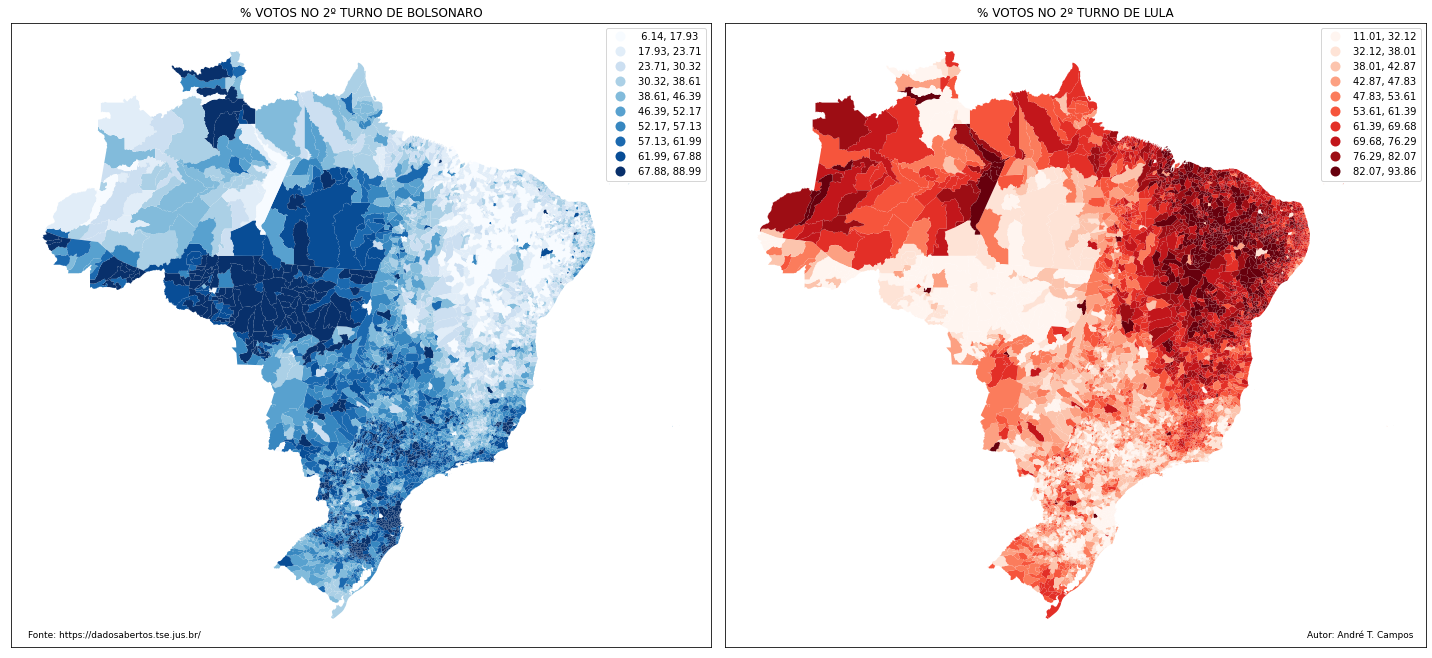

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,15), tight_layout = True)

ax = axs[0]
gdf.plot(ax=ax, column=gdf[f'perc_{candidat1}'], legend=True, cmap='Blues', scheme='Quantiles', k=10)
ax.set_xticks([])
ax.set_yticks([])
ax.text(-75,-35,'Fonte: https://dadosabertos.tse.jus.br/', fontsize=9)
ax.set_title(f'% VOTOS NO 2º TURNO DE {candidat1}');

ax = axs[1]
gdf.plot(ax=ax, column=gdf[f'perc_{candidat2}'], legend=True, cmap='Reds', scheme='Quantiles', k=10)
ax.set_xticks([])
ax.set_yticks([])
ax.text(-35,-35,'Autor: André T. Campos', fontsize=9)
ax.set_title(f'% VOTOS NO 2º TURNO DE {candidat2}');
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/TSE_BU_2022-2/mapa_calor_cand.png', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Use the colorbar set_ticks() method instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Use the colorbar set_ticks() method instead.


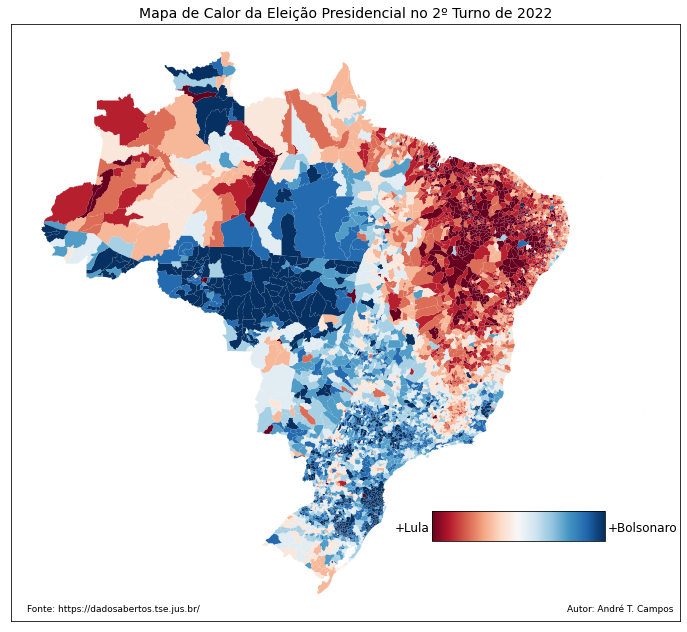

In [ ]:
ax = gdf.plot(column=gdf[f'perc_{candidat2}'], figsize=(12,12), cmap='RdBu_r', scheme='Quantiles', k=10)
ax.set_title('Mapa de Calor da Eleição Presidencial no 2º Turno de 2022', fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
#ax.grid()
ax.text(-75,-35,'Fonte: https://dadosabertos.tse.jus.br/', fontsize=9)
ax.text(-35,-35,'Autor: André T. Campos', fontsize=9)
ax.text(-47.75,-29.25,'+Lula', fontsize=12)
ax.text(-31.95,-29.25,'+Bolsonaro', fontsize=12)

# this is an inset axes over the main axes
axin = plt.axes([0.6125, 0.25, 0.2, 0.035])
color_map = mpl.cm.RdBu
normalizer = mpl.colors.Normalize(vmin = 0, vmax = 10)
 
plt.colorbar(mpl.cm.ScalarMappable(norm = normalizer, cmap = color_map), cax=axin,
               orientation ='horizontal', shrink=1.5, ticks=[], pad=0.01)

plt.xticks([])
plt.yticks([])
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/TSE_BU_2022-2/mapa_calor_tse2T.png', bbox_inches = 'tight', dpi=150)
plt.show()